In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

train = pd.read_csv('train.csv')
train['GHI'] = train['DNI']*math.cos(math.pi/180*63)+train['DHI']
submission = pd.read_csv('sample_submission.csv')
submission.set_index('id',inplace=True)

In [5]:
def eval_dewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [6]:
train['DP'] = 0
for i in range(len(train)):
    train.loc[i, ["DP"]] = eval_dewpoint(float(train.loc[i, ["T"]]), train.loc[i , ["RH"]])

In [7]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,DP
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,-16.522271
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,-16.525742
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,-16.061776
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,-16.066807
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,-15.500215


In [8]:
def transform(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels
x_col =['DHI','DNI','T', 'GHI', 'DP']
# x_col = ['DHI','DNI','WS', 'RH', 'T', 'TARGET','GHI']
y_col = ['TARGET']
dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

past_history = 48 * 2
future_target = 48 * 2

### transform train
train_data, train_label = transform(dataset, label, 0, None, past_history,future_target, 1)
### transform test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'drive/MyDrive/test/{i}.csv')
    tmp['GHI'] = tmp['DNI']*math.cos(math.pi/180*63)+tmp['DHI']
    tmp['DP'] = 0
    for i in range(len(tmp)):
        tmp.loc[i, ["DP"]] = eval_dewpoint(float(tmp.loc[i, ["T"]]), tmp.loc[i , ["RH"]])    
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

In [9]:
test.shape

(81, 480)

In [10]:
train_data = np.nan_to_num(train_data)

In [11]:
train_data.shape

(1091, 480)

In [12]:
train_label.shape

(1091, 96)

### max_features = 55

In [41]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor
features = []
N_ESTIMATORS =1000
for i in range(50, 101, 5):
    ETR = ExtraTreesRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=i, random_state=0,
                                    max_depth = 30,
                                    verbose=True,
                                    n_jobs=-1)
    ETR.fit(train_data, train_label)
    features.append(ETR.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   31.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.2

In [42]:
features, features.index(max(features))

([0.9999997277242723,
  0.9999997342996833,
  0.9999996508319071,
  0.9999996662600185,
  0.9999996847213883,
  0.9999997116672652,
  0.9999996616557737,
  0.9999996336680712,
  0.9999997278991093,
  0.9999995927001795,
  0.9999996536462519],
 1)

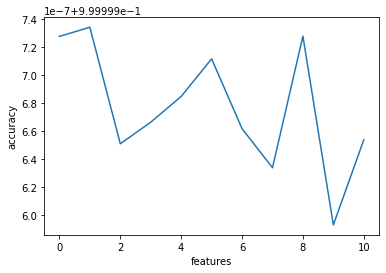

In [45]:
x = np.arange(0,11)
plt.xlabel("features")
plt.ylabel("accuracy")
plt.plot(x,features)
plt.show()

### max_depth = 40

In [46]:
# max_depth test = 20
depth = []
for i in range(20,40):
    ETR = ExtraTreesRegressor(n_estimators=1000,
                                    max_features=55, random_state=0,
                                    max_depth = i,
                                    verbose=True,
                                    n_jobs=-1)
    ETR.fit(train_data, train_label)
    depth.append(ETR.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.2

In [47]:
depth, depth.index(max(depth))

([0.9992060790049082,
  0.9995876211909002,
  0.9997867553412887,
  0.9998887724162798,
  0.9999459937048307,
  0.9999776453246905,
  0.999989739351707,
  0.9999955902714311,
  0.9999981704251749,
  0.9999992982846554,
  0.9999997342996833,
  0.9999998898953987,
  0.9999999619485079,
  0.9999999854897418,
  0.9999999947979085,
  0.9999999983165407,
  0.9999999992774088,
  0.9999999996889731,
  0.999999999886893,
  0.9999999999604688],
 19)

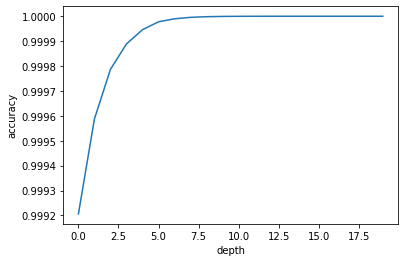

In [49]:
x = np.arange(0,20)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.plot(x,depth)
plt.show()

# n_estimator = 1000

In [36]:
# N_ESTIMATORS test = 20
n_estimators = []
for i in range(500,2001, 100):
    ETR = ExtraTreesRegressor(n_estimators=i,
                                    max_features=10, random_state=0,
                                    max_depth = 30,
                                    verbose=True,
                                    n_jobs=-1)
    ETR.fit(train_data, train_label)
    n_estimators.append(ETR.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call '

In [40]:
n_estimators, n_estimators.index(max(n_estimators))

([0.9999993378415297,
  0.9999993755042099,
  0.9999994179437395,
  0.9999994964180473,
  0.9999994924681576,
  0.9999994773588626,
  0.9999995202512788,
  0.9999994574381794,
  0.9999994366003424,
  0.9999994630337681,
  0.9999994273860835,
  0.9999994576370278,
  0.9999994791998787,
  0.9999994553718812,
  0.9999994988215697,
  0.9999994758435818],
 6)

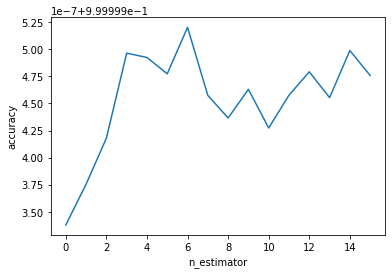

In [39]:
x = np.arange(0,16)
plt.xlabel("n_estimator")
plt.ylabel("accuracy")
plt.plot(x,n_estimators)
plt.show()

In [50]:
from sklearn.ensemble import ExtraTreesRegressor
N_ESTIMATORS = 1000
features = 55
depth = 40

ETR_model = ExtraTreesRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=features, random_state=0,
                                    max_depth = depth,
                                    verbose=True,
                                    n_jobs=-1)
ETR_model.fit(train_data, train_label)
print("Clear")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   28.1s


Clear


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.1s finished


In [54]:
ETR_pred = []
for estimator in ETR_model.estimators_:
#     print(estimator.predict(test).dtype)
    result = estimator.predict(test).astype(np.float64)
    ETR_pred.append(result)
ETR_pred = np.array(ETR_pred)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(ETR_pred, q * 100, axis=0)
    
    submission.iloc[:, i] = np.ravel(y_pred)

In [58]:
submission.to_csv(f'Extratrees.csv')